### Reconocimiento de dígitos impresos con MLP y CNN (dataset ESU23)


In [1]:
# Eugenio Sánchez | Noviembre 2023
# IIT | Comillas - ICAI

In [2]:
import util_mlp_cnn_ESU23
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# define hardware
device = torch.device('cpu')

#### 1. Recupera los modelos a utilizar

In [4]:
# arquitectura de la red (MLP dos capas)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.sigmo1 = nn.Sigmoid()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.l1(x)
        out = self.sigmo1(out)
        out = self.l2(out)
        out = self.softmax(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*14*14, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.main(x)
        return out
    

In [5]:
# Para recuperar un modelo
nombre_modelo_cnn = 'modelo_cnn_ajustado_2_epocas.pth'

# crea una instancia de los modelos
mlp = MLP(input_size = 28*28, hidden_size=100, num_classes=10)
cnn = CNN()

# carga en el modelo los pesos ajustados
mlp.load_state_dict(torch.load(os.path.join('modelos','mlp_3_epocas_ajustado_MNIST_2023_11_16.pth')))
cnn.load_state_dict(torch.load(os.path.join('modelos','cnn_2_epocas_ajustado_MNIST_2023_11_16.pth')))

<All keys matched successfully>

#### 2. Preparamos los datos y la carga del nuevo dataset

In [6]:
# Asegura que la imagen es de 28x28 píxeles, un único canal y normalizada ??
transforma_img = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: transforms.functional.invert(x)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

Tensor con el lote: torch.Size([100, 1, 28, 28])
Nº etiquetas del lote: torch.Size([100])


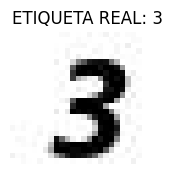

In [7]:
# define los datasets 
dir_imgs_ESU23 = os.path.join('data','ESU23')

tr_dataset = datasets.ImageFolder(os.path.join(dir_imgs_ESU23, 'TR'), transform = transforma_img)
ts_dataset = datasets.ImageFolder(os.path.join(dir_imgs_ESU23, 'TS'), transform = transforma_img)

# print(tr_dataset)
# print(ts_dataset)
# categorias = tr_dataset.classes
# print(f'Categorías de salida: {categorias}')

# crea los cargadores de datos
num_lotes = 100
train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = False)

# Comprueba que funciona
train_imgs, train_labels = next(iter(train_loader))
print(f"Tensor con el lote: {train_imgs.size()}")
print(f"Nº etiquetas del lote: {train_labels.size()}")

fig = plt.figure(1,figsize=(2, 2))
plt.imshow(train_imgs[0].squeeze(), cmap=plt.cm.binary)
plt.title(f'ETIQUETA REAL: {train_labels[0]}')
plt.axis('off')
plt.show()

#### 3. Calcula % aciertos y matrices de confusión en TS de los modelos ajustados con MNIST

mlp(TS) ----------
   Correctas (mlp(TS)):1576 Incorrectas(mlp(TS)):1574
   Aciertos (mlp(TS)): 50.032 %
cnn(TS) ----------
   Correctas (cnn(TS)):2254 Incorrectas(cnn(TS)):896
   Aciertos (cnn(TS)): 71.556 %


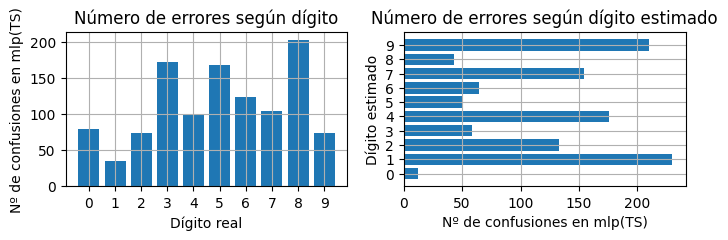

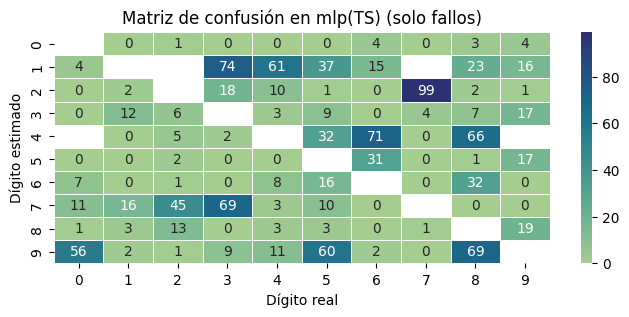

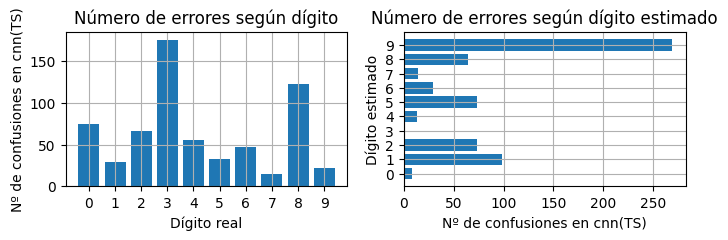

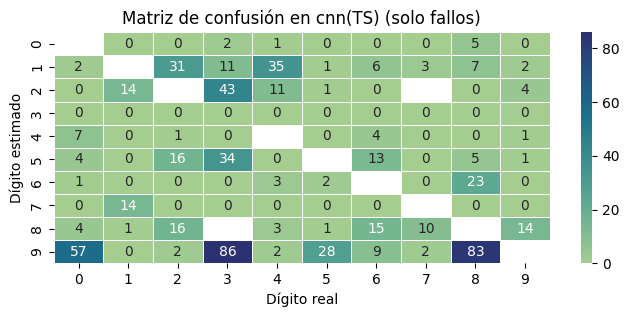

In [8]:
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, mlp, 'mlp(TS)', hacer_reshape = True)
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, cnn, 'cnn(TS)', hacer_reshape = False)

util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, mlp, 'mlp(TS)', 10, hacer_reshape = True)
util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, cnn, 'cnn(TS)', 10, hacer_reshape = False)

#### 4. Análisis imágenes ESU23 mal clasificadas

In [9]:
# util_mlp_cnn_ESU23.muestra_ejemplos_fallos(test_loader, mlp, 'mlp(TS)', digito=8, hacer_reshape = True)

In [10]:
# util_mlp_cnn_ESU23.muestra_ejemplos_fallos(test_loader, cnn, 'cnn(TS)', digito=8, hacer_reshape = False)

#### 5. Rehace el clasificador de la CNN para adaptarla al nuevo problema (transfer learning)

In [11]:
# cnn

In [12]:
# congela los parámetros hasta la capa Flatten
lista_componentes_congelar = range(5)
for c in lista_componentes_congelar:
    comp = cnn.main[c]
    for param in comp.parameters():  
        param.requires_grad = False

# cambia el clasificador final por uno nuevo   
cnn.main[6] = nn.Linear(64*14*14, 50)
cnn.main[7] = nn.ReLU()
cnn.main[8] = nn.Linear(50, 10)

In [13]:
# Reajusta el nuevo modelo 

# función de pérdida, ratio de aprendizaje y optimizador
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizador = torch.optim.Adam(cnn.parameters(), lr = learning_rate)

# nº de épocas
n_epochs = 2

Modelo ajustado en 2 épocas.


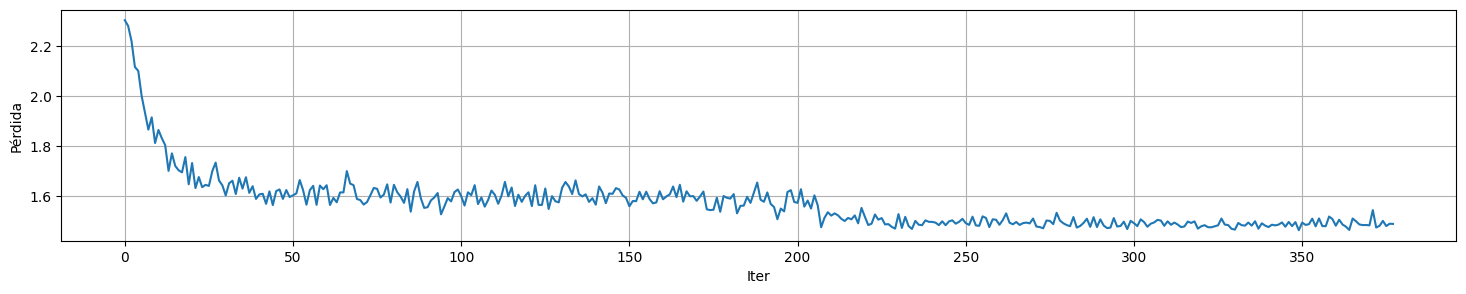

CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=10, bias=True)
    (9): Softmax(dim=1)
  )
)

In [14]:
# asegura modo training
cnn.train()

# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)

k=0
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = cnn(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backwards
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()
            
        if (i+1) % 200 == 0:
            print(f'Época: {epoch+1}/{n_epochs} '
                  f' - Step: {i+1}/{n_total_steps} :: loss = {loss.item()}')

print(f'Modelo ajustado en {n_epochs} épocas.')
fig = plt.figure(1,figsize=(18, 3))
plt.plot(tr_eval_loss)
plt.xlabel('Iter')
plt.ylabel('Pérdida')
plt.grid()
plt.show()


# pone modo evaluación
cnn.eval()

#### 6. Calcula % aciertos y matrices de confusión en TR y TS de la CNN re-acondicionada para ESU23

TR ----------
   Correctas (TR):18438 Incorrectas(TR):392
   Aciertos (TR): 97.918 %
TS ----------
   Correctas (TS):3080 Incorrectas(TS):70
   Aciertos (TS): 97.778 %


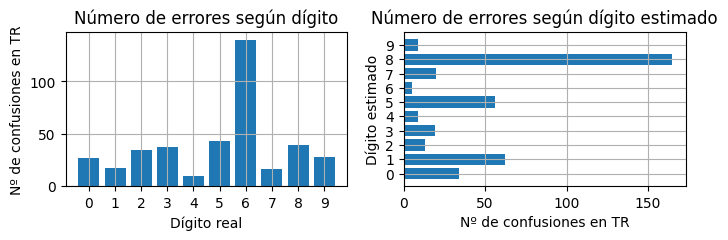

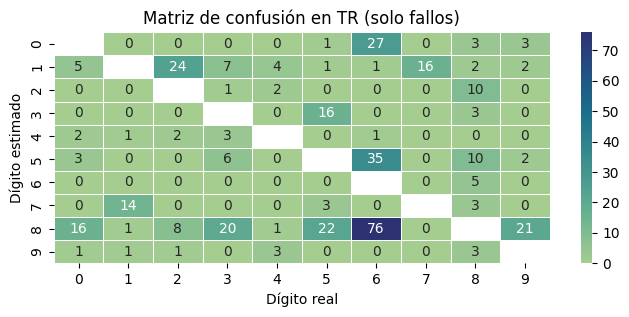

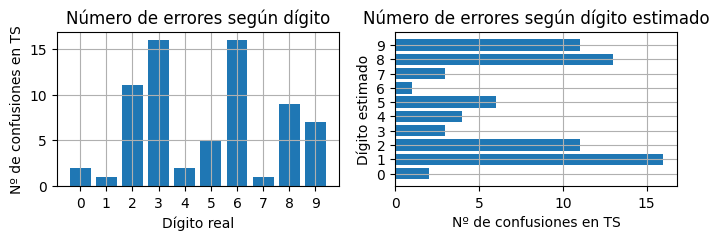

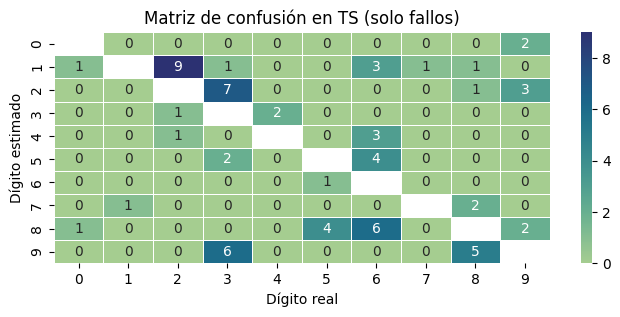

In [15]:
util_mlp_cnn_ESU23.calcula_aciertos_modelo(train_loader, cnn, 'TR', hacer_reshape = False)
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, cnn, 'TS', hacer_reshape = False)

util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(train_loader, cnn, 'TR', 10, hacer_reshape = False)
util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, cnn, 'TS', 10, hacer_reshape = False)

Muestra 100 ejemplos de imágenes mal clasificadas en TS:


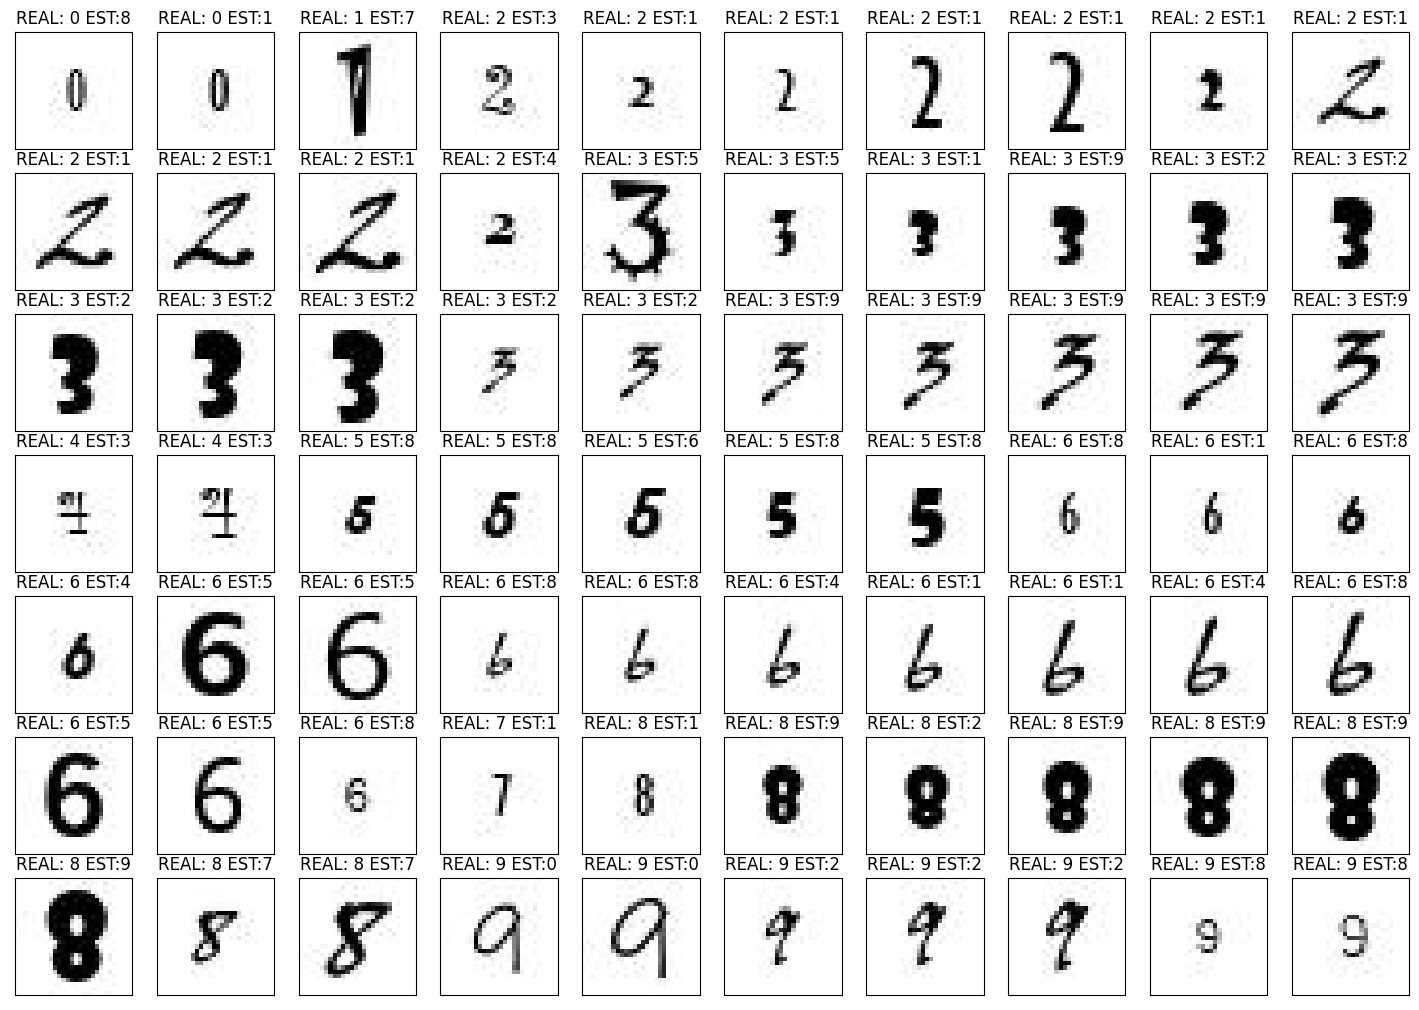

Muestra 20 ejemplos de imágenes mal clasificadas en TS del dígito 8:


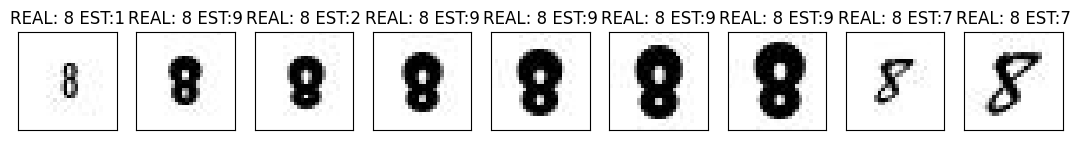

In [16]:
util_mlp_cnn_ESU23.muestra_ejemplos_fallos(test_loader, cnn, 'TS', digito=8, hacer_reshape = False)